In [1]:
import sys
sys.path.append('..')

import random
import torch

In [2]:
from nodes import NODE_CLASS_MAPPINGS
from comfy.wunderbar.common import get_value_at_index

Total VRAM 5931 MB, total RAM 31931 MB
Set vram state to: NORMAL_VRAM
Device: cuda:0 NVIDIA GeForce RTX 3060 Laptop GPU : native
VAE dtype: torch.bfloat16
Using pytorch cross attention


In [5]:
talent_image_path = "miki-fujimoto_4.webp"
positive_prompt_text = ""
negative_prompt_text = "nsfw, nude"
queue_size = 1
width = 512
height = 512
steps = 20
cfg = 8
sampler_name = "euler"
scheduler = "normal"
denoise = 1
vae_tile_size = 512
filename_prefix="Wunderbar_Revision_Demo"

In [8]:
with torch.inference_mode():
    checkpoint_loader_node = NODE_CLASS_MAPPINGS["CheckpointLoaderSimple"]()
    checkpoint = checkpoint_loader_node.load_checkpoint(
        ckpt_name="checkpoints/sd15_realisticVision_v51.safetensors"
    )

    cliptext_encoder_node = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
    
    positive_prompt = cliptext_encoder_node.encode(
        text=positive_prompt_text, 
        clip=get_value_at_index(checkpoint, 1)
    )
    negative_prompt = cliptext_encoder_node.encode(
        text=negative_prompt_text, clip=get_value_at_index(checkpoint, 1)
    )

    empty_latent_image_generator_node = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()
    empty_latent_image = empty_latent_image_generator_node.generate(
        width=width, height=height, batch_size=1
    )
    
    image_saver_node = NODE_CLASS_MAPPINGS["SaveImage"]()

    ksampler_node = NODE_CLASS_MAPPINGS["KSampler"]()
    
    vae_tiled_decoder_node = NODE_CLASS_MAPPINGS["VAEDecodeTiled"]()
    
    # for q in range(queue_size):
    ksampler = ksampler_node.sample(
        seed=random.randint(1, 2**64),
        steps=steps,
        cfg=cfg,
        sampler_name=sampler_name,
        scheduler=scheduler,
        denoise=denoise,
        model=get_value_at_index(checkpoint, 0),
        positive=get_value_at_index(positive_prompt, 0),
        negative=get_value_at_index(negative_prompt, 0),
        latent_image=get_value_at_index(empty_latent_image, 0),
    )

    vae_decoder = vae_tiled_decoder_node.decode(
        tile_size=vae_tile_size,
        samples=get_value_at_index(ksampler, 0),
        vae=get_value_at_index(checkpoint, 2),
    )

    output_image = image_saver_node.save_images(
        filename_prefix=filename_prefix,
        images=get_value_at_index(vae_decoder, 0),
    )

model_type EPS
Using pytorch attention in VAE
Using pytorch attention in VAE
clip missing: ['clip_l.logit_scale', 'clip_l.transformer.text_projection.weight']
Requested to load SD1ClipModel
Loading 1 new model
Requested to load BaseModel
Loading 1 new model


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencoderKL
Loading 1 new model


In [9]:
output_image

{'ui': {'images': [{'filename': 'Wunderbar_Revision_Demo_00003_.png',
    'subfolder': '',
    'type': 'output'}]}}

In [10]:
from PIL import Image

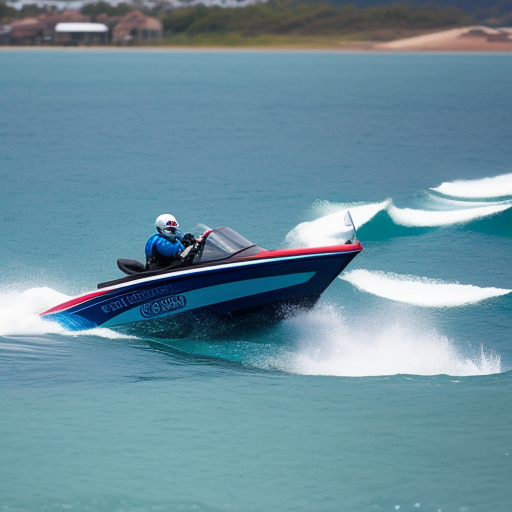

In [13]:
Image.open(f"../output/{output_image['ui']['images'][0]['filename']}")